In [1]:
import glob
import os
from enterprise.signals import parameter
from enterprise.signals import white_signals 
from enterprise.signals import gp_signals 
from enterprise.signals import utils         
from enterprise.signals import signal_base    
from enterprise.pulsar import Pulsar 
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise_extensions.blocks import white_noise_block, red_noise_block, dm_noise_block
import numpy as np
import corner

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
parfiles= sorted(glob.glob('/data/' + 'test_3.par'))
timfiles = sorted(glob.glob('/data/'+ 'combined_dm_red.tim'))

In [3]:
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    print(psr)
    psrs.append(psr)
    print(psrs)

In [4]:
# Uniform prior on EFAC
efac = parameter.Constant(1.0)

# tmin = [p.toas.min() for p in psrs]
# tmax = [p.toas.max() for p in psrs]
# Tspan = np.max(tmax) - np.min(tmin)

# log10_A_dm = parameter.Uniform(-20, -11)
# gamma_dm = parameter.Uniform(0, 7)
# dm_prior = utils.powerlaw(log10_A=log10_A_dm, gamma=gamma_dm)
# dm_basis = utils.createfourierdesignmatrix_dm(nmodes=30, Tspan=Tspan)
# dmgp = gp_signals.BasisGP(dm_prior, dm_basis, name='dm_gp', coefficients=False)

# log10_A = parameter.Uniform(-20, -11)
# gamma = parameter.Uniform(0, 7) 
# pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
# rn = gp_signals.FourierBasisGP(spectrum=pl, components=30)


# ef = white_signals.MeasurementNoise(efac=efac)
# tm = gp_signals.TimingModel(use_svd=True)

# model = ef + dmgp + tm + rn

s = gp_signals.TimingModel(use_svd=True)

s += red_noise_block(components=30)

s += dm_noise_block(components=30)

s += white_signals.MeasurementNoise(efac=efac)

model = s

# # initialize PTA
pta = signal_base.PTA([model(psrs[0])])

In [5]:
help(gp_signals.TimingModel)

Help on function TimingModel in module enterprise.signals.gp_signals:

TimingModel(coefficients=False, name='linear_timing_model', use_svd=False, normed=True, idx_exclude=None)
    Class factory for marginalized linear timing model signals.



In [6]:
print(pta.params)

[fake_test_3_dm_gp_gamma:Uniform(pmin=0, pmax=7), fake_test_3_dm_gp_log10_A:Uniform(pmin=-20, pmax=-11), fake_test_3_red_noise_gamma:Uniform(pmin=0, pmax=7), fake_test_3_red_noise_log10_A:Uniform(pmin=-20, pmax=-11)]


In [7]:
xs = {par.name: par.sample() for par in pta.params} #Перебирает все параметры модели.

#par.name: Получает имя параметра
#par.sample(): Генерирует случайное значение параметра согласно его априорному распределению 
print(xs)


{'fake_test_3_dm_gp_gamma': 4.973263688674816, 'fake_test_3_dm_gp_log10_A': -14.819980186632854, 'fake_test_3_red_noise_gamma': 1.1633747689708756, 'fake_test_3_red_noise_log10_A': -14.24920125845362}


In [8]:
# # dimension of parameter space
ndim = len(xs)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2) #Создаёт диагональную матрицу размерности ndim x ndim с элементами 0.0001задаёт начальный размер "шага" сэмплера по каждому параметру 

# # set up jump groups by red noise groups
ndim = len(xs)
groups  = [range(0, ndim)]#создаёт группу из всех параметров
groups.extend([[0,1]])#добавляет отдельную группу для параметров с индексами 1 и 2, Ускоряет сходимость, обновляя коррелированные параметры (например, амплитуду и спектральный индекс) совместно.
# intialize sampler
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, groups=groups, outDir='/data')

In [9]:
# sampler for N steps
N = 100000 #общее количество итераций MCMC
x0 = np.hstack(p.sample() for p in pta.params) 
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

/tmp/ipykernel_63699/2842193613.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x0 = np.hstack(p.sample() for p in pta.params)


Finished 1.00 percent in 0.473296 s Acceptance rate = 0.824

/usr/local/lib/python3.10/dist-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Adding DE jump with weight 5058444 s Acceptance rate = 0.21733
Finished 100.00 percent in 37.543256 s Acceptance rate = 0.32814
Run Complete


In [11]:
chain = np.loadtxt('/data/chain_1.txt') #загружаются данные цепочки MCMC из файла
pars = sorted(xs.keys())
burn = int(0.25 * chain.shape[0])#первые 25% шагов цепочки отбрасываются 

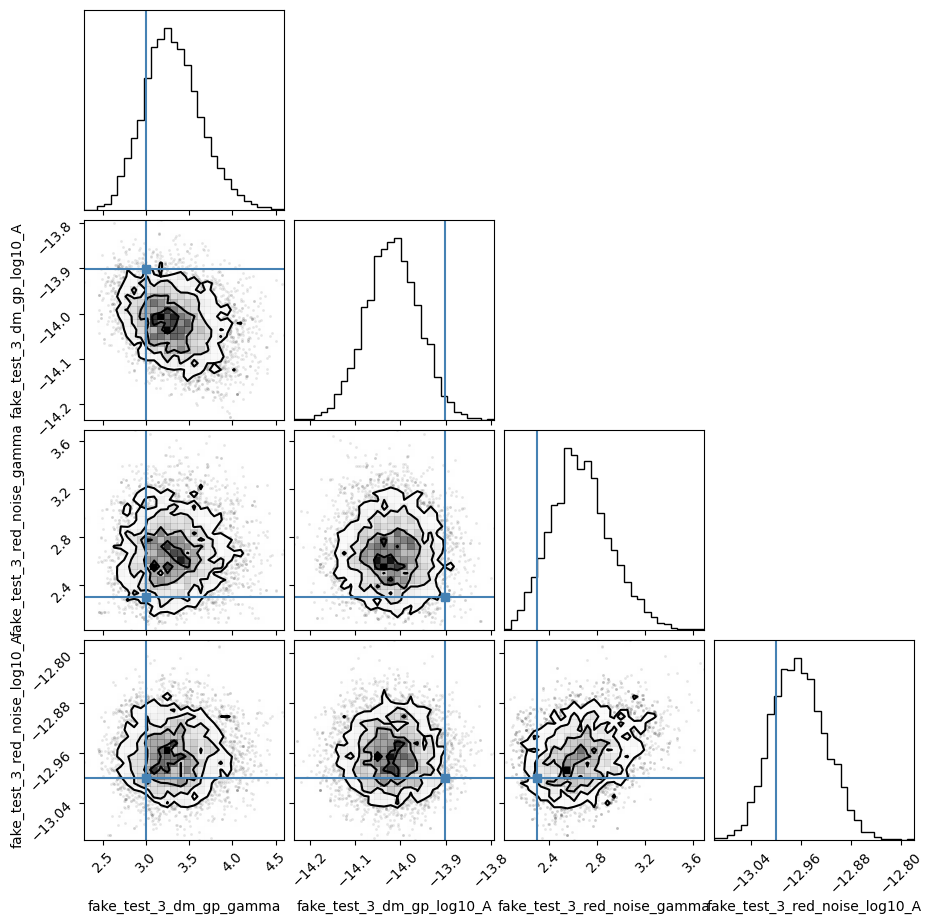

In [18]:
truths = [3, np.log10(5e-12)-2.6, 2.3, np.log10(1e-13)]#задаются эталонные значения параметров для сравнения с результатами MCMC.
corner.corner(chain[burn:,:-4], 30, truths=truths, labels=pars);